# The journey to scale
- From Logistic Regressor to Perceptron
- From Perceptron to MLP
- Increasing sequence length

Now:
- *Adding more layers*
- Making sure we can train on so many layers

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt 
import LucaM185
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.mps.is_available() else "cpu")
STEPS, BATCH_SIZE = 3000, 4096


# Loading the dataset

In [2]:
with open("datasets/tinyShakespeare.txt", "r") as f:
    load = f.read()
print(load[:200])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you


In [3]:
texttoint = {elm: n for n, elm in enumerate(set(load))}
inttotext = {n:elm for n, elm in enumerate(set(load))}
dataset = [texttoint[c] for c in load]

vocab_size = len(texttoint)
sequence_length = 20

sequences = torch.tensor([dataset[i:-sequence_length+i-1] for i in range(sequence_length+1)]).T
inputs = sequences[2000:, :-1]
labels = sequences[2000:, -1]
val_inputs = sequences[:2000, :-1]
val_labels = sequences[:2000, -1]

# Deeper Network (2 hidden layers)

To get from the perceptron to mlp we expanded the model by scaling the input dimension. Now we can try to make it deeper, with more operations happening in series. <br>


_Curious note: biological neurons fire around 100 times a second, it takes a human 100ms to identify an object, so it stands to reason that a 10 layer network may be able to do complex tasks._

Millions of parameters: 0.08
Step ___0 - Loss: 4.177 - Val Loss: 4.167
Step _300 - Loss: 2.566 - Val Loss: 2.628
Step _600 - Loss: 2.318 - Val Loss: 2.433
Step _900 - Loss: 2.120 - Val Loss: 2.352


Step 1200 - Loss: 2.055 - Val Loss: 2.161
Step 1500 - Loss: 2.011 - Val Loss: 2.061
Step 1800 - Loss: 1.930 - Val Loss: 2.049
Step 2100 - Loss: 1.887 - Val Loss: 2.008
Step 2400 - Loss: 1.860 - Val Loss: 1.779
Step 2700 - Loss: 1.840 - Val Loss: 1.977


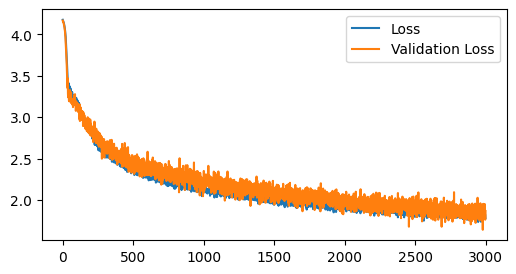

In [4]:
class Model(nn.Module):
    def __init__(self, emb_size, hidden_size, n_layers):
        super().__init__()
        self.embeddings = nn.Embedding(vocab_size, emb_size)
        self.fc_in = nn.Linear(emb_size*sequence_length, hidden_size)
        self.fc_hidden = nn.ModuleList([nn.Linear(hidden_size, hidden_size) for _ in range(n_layers)]) # this is a list of linear layers
        self.fc_out = nn.Linear(hidden_size, vocab_size)
    
    def forward(self, inputs):
        emb = self.embeddings(inputs).view(inputs.shape[0], -1)
        x = F.gelu(self.fc_in(emb))
        for hidden in self.fc_hidden:    # iterating over hidden layers
            x = F.gelu(hidden(x))  # applying each hidden layer
        return self.fc_out(x)


model = Model(emb_size=16, hidden_size=128, n_layers=2).to(device)


# We are moving our training loop in a function so that it's more reusable later
def train(model, inputs, labels, val_inputs, val_labels, steps, batch_size):
    print(f"Millions of parameters: {sum(p.numel() for p in model.parameters())/1e6:.2f}")
    optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)  

    lossi = []
    vlossi = []

    for step in range(steps):
        indexes = torch.randint(0, len(inputs), (batch_size,))
        
        pred = model(inputs[indexes].to(device)) 
        loss = F.cross_entropy(pred, labels[indexes].to(device))

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        lossi.append(loss.item())
        
        with torch.no_grad():
            indexes = torch.randint(0, len(val_inputs), (batch_size//8,))
            pred = model(val_inputs[indexes].to(device))
            vloss = F.cross_entropy(pred, val_labels[indexes].to(device))
            vlossi.append(vloss.item())
            
        if step % (steps//10) == 0:
            print(f"Step {step:_>4d} - Loss: {loss.item():.3f} - Val Loss: {vloss.item():.3f}")
        

    plt.figure(figsize=(6, 3))  
    plt.plot(lossi, label='Loss')
    plt.plot(vlossi, label='Validation Loss')
    plt.legend()

train(model, inputs, labels, val_inputs, val_labels, steps=STEPS, batch_size=BATCH_SIZE)

# Much deeper network (20 layers)

Showing off the absolute reusability of torch.nn.Module and simple functions

Millions of parameters: 0.38
Step ___0 - Loss: 4.177 - Val Loss: 4.175


Step _300 - Loss: 2.981 - Val Loss: 2.917
Step _600 - Loss: 2.691 - Val Loss: 2.785
Step _900 - Loss: 2.537 - Val Loss: 2.567
Step 1200 - Loss: 2.432 - Val Loss: 2.445
Step 1500 - Loss: 2.389 - Val Loss: 2.398
Step 1800 - Loss: 2.366 - Val Loss: 2.482
Step 2100 - Loss: 2.349 - Val Loss: 2.453
Step 2400 - Loss: 2.285 - Val Loss: 2.389
Step 2700 - Loss: 2.267 - Val Loss: 2.196


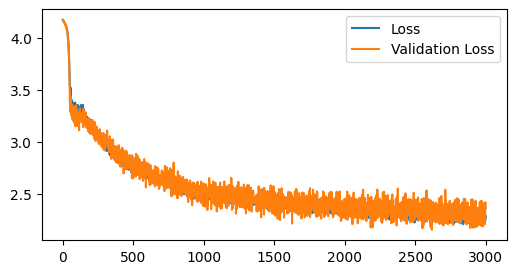

In [5]:
model = Model(emb_size=16, hidden_size=128, n_layers=20).to(device)  # increased to 20 layers 

train(model, inputs, labels, val_inputs, val_labels, steps=STEPS, batch_size=BATCH_SIZE)

The network with 20 hidden layers is unable to train effectively, thats because the derivatives don't flow well between the layers

# Residual connections

Millions of parameters: 0.38
Step ___0 - Loss: 6.228 - Val Loss: 4.883


Step _300 - Loss: 2.225 - Val Loss: 2.454
Step _600 - Loss: 1.924 - Val Loss: 1.995
Step _900 - Loss: 1.734 - Val Loss: 1.804
Step 1200 - Loss: 1.678 - Val Loss: 1.633
Step 1500 - Loss: 1.602 - Val Loss: 1.792
Step 1800 - Loss: 1.594 - Val Loss: 1.641
Step 2100 - Loss: 1.522 - Val Loss: 1.691
Step 2400 - Loss: 1.520 - Val Loss: 1.572
Step 2700 - Loss: 1.461 - Val Loss: 1.481


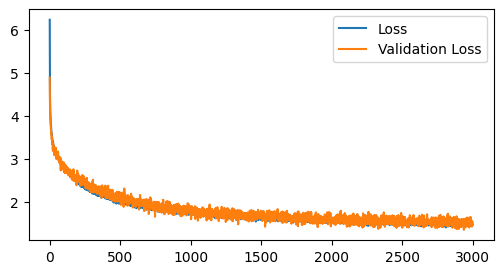

In [6]:
class Model(nn.Module):
    def __init__(self, emb_size, hidden_size, n_layers):
        super().__init__()
        self.embeddings = nn.Embedding(vocab_size, emb_size)
        self.fc_in = nn.Linear(emb_size*sequence_length, hidden_size)
        self.fc_hidden = nn.ModuleList([nn.Linear(hidden_size, hidden_size) for _ in range(n_layers)]) 
        self.fc_out = nn.Linear(hidden_size, vocab_size)
    
    def forward(self, inputs):
        emb = self.embeddings(inputs).view(inputs.shape[0], -1)
        x = F.gelu(self.fc_in(emb))
        for hidden in self.fc_hidden: 
            x = x + F.gelu(hidden(x))  # added skip connection 
        return self.fc_out(x)
    

model = Model(emb_size=16, hidden_size=128, n_layers=20).to(device)


# A change in the forward pass doesn't affect the training loop
train(model, inputs, labels, val_inputs, val_labels, steps=STEPS, batch_size=BATCH_SIZE)

In a standard layer, `x = linear(x)` completely transforms the input, which can make learning identity mappings harder. With residual connections, `x = x + linear(x)`, allowing the network to retain the original input while learning incremental changes. This improves gradient flow, facilitates identity learning, and enhances stability, especially in deep networks.

# Deeper (56 layers) 

Millions of parameters: 0.98
Step ___0 - Loss: 11530.983 - Val Loss: 3412.261


Step _300 - Loss: 3.364 - Val Loss: 3.366
Step _600 - Loss: 3.168 - Val Loss: 3.097
Step _900 - Loss: 3.061 - Val Loss: 3.155
Step 1200 - Loss: 2.922 - Val Loss: 3.114
Step 1500 - Loss: 2.831 - Val Loss: 2.959
Step 1800 - Loss: 2.758 - Val Loss: 2.895
Step 2100 - Loss: 2.633 - Val Loss: 2.675
Step 2400 - Loss: 2.553 - Val Loss: 2.743
Step 2700 - Loss: 2.446 - Val Loss: 2.521


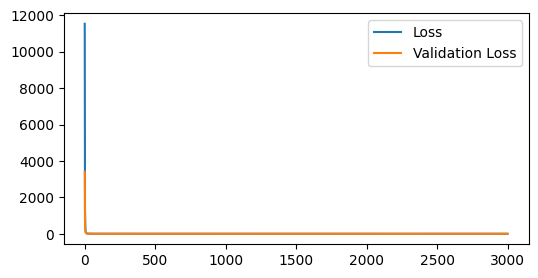

In [7]:
model = Model(emb_size=16, hidden_size=128, n_layers=56).to(device)  # increased to 56 layers

train(model, inputs, labels, val_inputs, val_labels, steps=STEPS, batch_size=BATCH_SIZE)

# Normalization

Deeper networks allow for more layers, but often result in high loss initially. While we previously addressed this by decreasing parameter values at initialization, going too low can cause excessively small values. To prevent this, we normalize the neurons using layer normalization, ensuring a that the model has control over mean and std

Millions of parameters: 0.99
Step ___0 - Loss: 4.313 - Val Loss: 4.159


Step _300 - Loss: 1.945 - Val Loss: 2.161
Step _600 - Loss: 1.657 - Val Loss: 1.492
Step _900 - Loss: 1.543 - Val Loss: 1.461
Step 1200 - Loss: 1.508 - Val Loss: 1.501
Step 1500 - Loss: 1.425 - Val Loss: 1.460
Step 1800 - Loss: 1.398 - Val Loss: 1.409
Step 2100 - Loss: 1.363 - Val Loss: 1.570
Step 2400 - Loss: 1.351 - Val Loss: 1.553
Step 2700 - Loss: 1.358 - Val Loss: 1.536


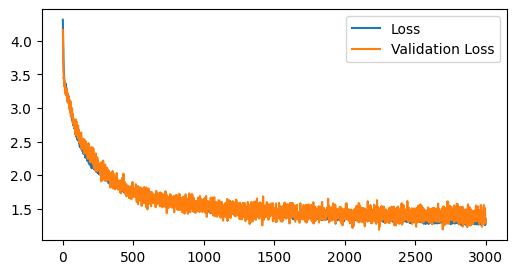

In [8]:
class Model(nn.Module):
    def __init__(self, emb_size, hidden_size, n_layers):
        super().__init__()
        self.embeddings = nn.Embedding(vocab_size, emb_size)
        self.fc_in = nn.Linear(emb_size*sequence_length, hidden_size)
        self.fc_hidden = nn.ModuleList([nn.Linear(hidden_size, hidden_size) for _ in range(n_layers)]) 
        self.fc_out = nn.Linear(hidden_size, vocab_size)
        self.norms = nn.ModuleList([nn.LayerNorm(hidden_size) for _ in range(n_layers+1)])  # using individual norms for each layer

    def forward(self, inputs):
        emb = self.embeddings(inputs).view(inputs.shape[0], -1)
        x = F.gelu(self.fc_in(emb))
        for n, hidden in enumerate(self.fc_hidden): 
            x = x + F.gelu(hidden(self.norms[n](x)))  # Added normalization step before the Linear
        return self.fc_out(self.norms[-1](x)) 


model = Model(emb_size=16, hidden_size=128, n_layers=56).to(device)


train(model, inputs, labels, val_inputs, val_labels, steps=STEPS, batch_size=BATCH_SIZE)

In [9]:
string = "             \nKING RICHARD I"
print(string, end="")

with torch.no_grad():
    model.eval()
    for _ in range(300):
        X = torch.tensor([texttoint[s] for s in string[-sequence_length:]]).long().view(1, -1).to(device)
        pred = model.forward(X)
        string += inttotext[torch.multinomial(F.softmax(pred, dim=1), 1).item()]
        print(string[-1], end="")
    model.train()


             
KING RICHARD III:
Tut, being two ill pretties,
Profi? Katting.

KING LEKrARD:
No, gext, an any with the fine,
Is it is not back them,
And of the house.

ANTIGONUS:
Ay, I en

joy'd! then he been your power.
You love to him mine, here mough coudly find therefore away;
He candent
On commands,
To take you that I sell p

finally the text generated from the model makes some sense

# WAYY TOO DEEP
Just for fun lets try way more layers

Millions of parameters: 3.40
Step ___0 - Loss: 4.328 - Val Loss: 4.079


Step _300 - Loss: 1.947 - Val Loss: 1.937
Step _600 - Loss: 1.635 - Val Loss: 1.707
Step _900 - Loss: 1.546 - Val Loss: 1.447
Step 1200 - Loss: 1.414 - Val Loss: 1.515
Step 1500 - Loss: 1.436 - Val Loss: 1.478
Step 1800 - Loss: 1.361 - Val Loss: 1.393
Step 2100 - Loss: 1.302 - Val Loss: 1.500
Step 2400 - Loss: 1.335 - Val Loss: 1.426
Step 2700 - Loss: 1.324 - Val Loss: 1.483


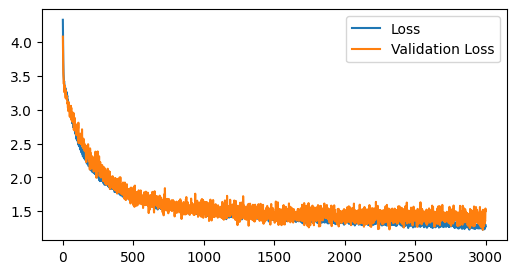

In [10]:
model = Model(emb_size=16, hidden_size=128, n_layers=200).to(device)  # increased to 200 layers

train(model, inputs, labels, val_inputs, val_labels, steps=STEPS, batch_size=BATCH_SIZE)

# Limits to scale
The performance of the model is not improving in any way, it stands to reason that we are saturating the 20 character sequence length with those big models. We will now explore new ways of increasing sequence length in the next sections

# Scaling width
The number of layer is not the only way to scale. We can also make the layers wider. 
The complexity of each layer goes up with N^3 of the hidden size, but we have gpus which are extremely good at big matmuls, so we can actually increase the hidden size quite a lot before noticing it slow down

Millions of parameters: 3.33
Step ___0 - Loss: 4.372 - Val Loss: 3.910


Step _150 - Loss: 1.848 - Val Loss: 1.994
Step _300 - Loss: 1.616 - Val Loss: 1.735
Step _450 - Loss: 1.530 - Val Loss: 1.602
Step _600 - Loss: 1.447 - Val Loss: 1.510
Step _750 - Loss: 1.333 - Val Loss: 1.500
Step _900 - Loss: 1.328 - Val Loss: 1.481
Step 1050 - Loss: 1.236 - Val Loss: 1.583
Step 1200 - Loss: 1.239 - Val Loss: 1.561
Step 1350 - Loss: 1.194 - Val Loss: 1.428


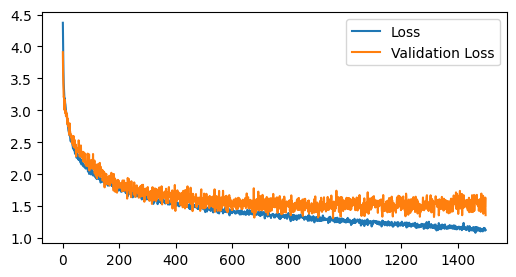

In [11]:
model = Model(emb_size=64, hidden_size=512, n_layers=10).to(device)

train(model, inputs, labels, val_inputs, val_labels, steps=STEPS//2, batch_size=BATCH_SIZE)

Even tho scaling the model this way seems to increase the gap between train and validation, but we are nearly getting the performance of the 56 layer MLP in less than half the time